In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as ipw
import tensorflow as tf
from ipywidgets import interactive
import pickle
import json
import random
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import os
from tensorflow.contrib.tensorboard.plugins import projector

/home/adam/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from tensorflow.contrib.slim.nets import resnet_v1
from tensorflow.contrib import slim

## Load Data

In [4]:
def get_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content)).convert('RGB').resize((224, 224))
    else:
        raise AttributeError("Wrong url")

class MSCOCO(object):
    def __init__(self, anotations_path='data/mscoco/annotations/instances_val2017.json', 
                 data_path_prefix='./data/mscoco/val2017/'):
        self.coco_anotations = json.load(open(anotations_path, 'r'))
        self.data_path_prefix = data_path_prefix
        
        self.img_id2img_path = {}
        self.img_id2coco_id = {}
        self.coco_id2name = {}
    
        for item in self.coco_anotations['images']:
            self.img_id2img_path[item['id']] = item['file_name']

        for item in self.coco_anotations['annotations']:
            self.img_id2coco_id[item['image_id']] = item['category_id']

        for item in self.coco_anotations['categories']:
            self.coco_id2name[item['id']] = item['name']
    
    def get_random_sample(self):
        image_id = random.sample(list(self.img_id2coco_id.keys()), 1)[0]
    
        image_path = os.path.join(self.data_path_prefix, self.img_id2img_path[image_id])
        image = Image.open(open(image_path, 'rb')).convert('RGB').resize((224, 224))
        description = self.coco_id2name[self.img_id2coco_id[image_id]]
        return image, description

In [32]:
mscoco = MSCOCO(anotations_path='data/mscoco/annotations_train/instances_train2017.json',
                data_path_prefix='data/mscoco/train2017/')

In [33]:
class_id2class_name_mapping = {
    0: 'cow',
    1: 'sheep',
    2: 'giraffe',
    3: 'horse',
    4: 'bird',
    5: 'cat',
    6: 'dog',
    7: 'elephant',
    8: 'bear'}

In [34]:
cows = list(map(lambda item: item[0],(filter(lambda item: item[1]==21, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
sheeps = list(map(lambda item: item[0],(filter(lambda item: item[1]==20, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
giraffes = list(map(lambda item: item[0],(filter(lambda item: item[1]==25, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
horses = list(map(lambda item: item[0],(filter(lambda item: item[1]==19, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
birds = list(map(lambda item: item[0],(filter(lambda item: item[1]==16, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
cats = list(map(lambda item: item[0],(filter(lambda item: item[1]==17, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
dogs = list(map(lambda item: item[0],(filter(lambda item: item[1]==18, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
elephants = list(map(lambda item: item[0],(filter(lambda item: item[1]==22, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))
bears = list(map(lambda item: item[0],(filter(lambda item: item[1]==23, [(img_id, coco_id) for (img_id, coco_id) in mscoco.img_id2coco_id.items()]))))



In [35]:
img_ids = cows + sheeps + giraffes + horses + birds + cats + dogs + elephants + bears

In [36]:
img_paths = [mscoco.img_id2img_path[img_id] for img_id in img_ids]

In [37]:
ids = [0 for cow in  cows] + [1 for sheep in sheeps] + [2 for giraf in giraffes] + [3 for horse in horses] + [4 for bird in birds] + [5 for cat in cats] + [6 for dog in dogs] + [7 for elephant in elephants] + [8 for bear in bears]
labels_onehot = np.zeros([len(ids), 9]).tolist()
for i in range(len(labels_onehot)):
    labels_onehot[i][ids[i]] = 1.

In [38]:
len(img_ids)

11317

In [39]:
df_data = pd.DataFrame(
    {"images": img_paths,
     "labels": labels_onehot})

In [40]:
df_data.to_hdf("data/mscoco/train_data.hdf", "data")

/home/adam/.pyenv/versions/3.6.3/envs/3.6.3.gpu/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['images', 'labels']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [264]:
class Dataset(object):
    def __init__(self, dataframe, data_path_prefix):
        self.data = pd.read_hdf(dataframe, 'data')
        self.data_path_prefix = data_path_prefix
        self.size = 224
        
    @property    
    def images(self):
        return self._get_image_batch(self.data)
    
    @property
    def labels(self):
        return np.array(self.data['labels'].values.tolist())

    def next_batch(self, size):
        data_sample = self.data.sample(size)
        return self._get_image_batch(data_sample), np.array(data_sample['labels'].values.tolist())


    def _get_image_batch(self, df):
        imgs = []
        for img in df.images:
            img_path = os.path.join(self.data_path_prefix, img)
            np_img = np.array(Image.open(open(img_path, 'rb')).convert('RGB').resize((self.size, self.size)))
            np_img = np_img.reshape(1, self.size, self.size, 3)
            imgs.append(np_img)
        return np.vstack(imgs)


In [265]:
class data:
    train = Dataset('./data/mscoco/train_data.hdf', './data/mscoco/train2017/')
    validation = Dataset('./data/mscoco/valid_data.hdf', './data/mscoco/val2017/')

In [194]:
img, desc = mscoco.get_random_sample()

In [195]:
url = "http://cdn2-www.dogtime.com/assets/uploads/gallery/samoyed-dogs-and-puppies/samoyed-dogs-puppies-8.jpg"
img = get_image_from_url(url)

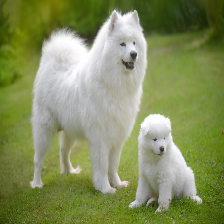

In [196]:
img

In [200]:
img = np.array(img).reshape([1,224,224,3])

## Process img

 - https://github.com/tensorflow/models/tree/master/research/slim 
 - https://github.com/tensorflow/models/blob/master/research/slim/nets/resnet_v1.py
 - resnet_arg_scope: list of nodes with default param setting 
 - decorate all with add_arg_scope
 - resnet_argscope returns slim_argscope instance       

In [201]:
with open('data/checkpoints/resnet_v1_50_catnames.pickle', 'rb') as handle:
    imagenet_category_names = pickle.load(handle)

In [206]:
resnet_model_ckpt = 'data/checkpoints/resnet_v1_50.ckpt'
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('inputs'):
        ph_image = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
        ph_is_training = tf.placeholder(tf.bool)
        
    with slim.arg_scope(resnet_v1.resnet_arg_scope()):
        tf_output_logits, tf_othere_layers = resnet_v1.resnet_v1_50(ph_image,
                                                output_stride=None,
                                                num_classes=1000,
                                                global_pool=True,
                                                is_training=ph_is_training,
                                                scope='resnet_v1_50')
    with tf.name_scope('softmax_output'):
        tf_output_softmax = tf.nn.softmax(tf.reshape(tf_output_logits, shape=(-1, 1000)))
    
    tf_init_resnet = slim.assign_from_checkpoint_fn(
        resnet_model_ckpt, 
        slim.get_model_variables('resnet_v1_50'))
    
    tf_variables_initializer = tf.group(
        tf.global_variables_initializer(),
        tf.local_variables_initializer())

In [207]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run([tf_variables_initializer])
    tf_init_resnet(session)
    output_softmax = session.run([tf_output_softmax], feed_dict={ph_is_training: False, ph_image: img})[0]

INFO:tensorflow:Restoring parameters from data/checkpoints/resnet_v1_50.ckpt


INFO:tensorflow:Restoring parameters from data/checkpoints/resnet_v1_50.ckpt


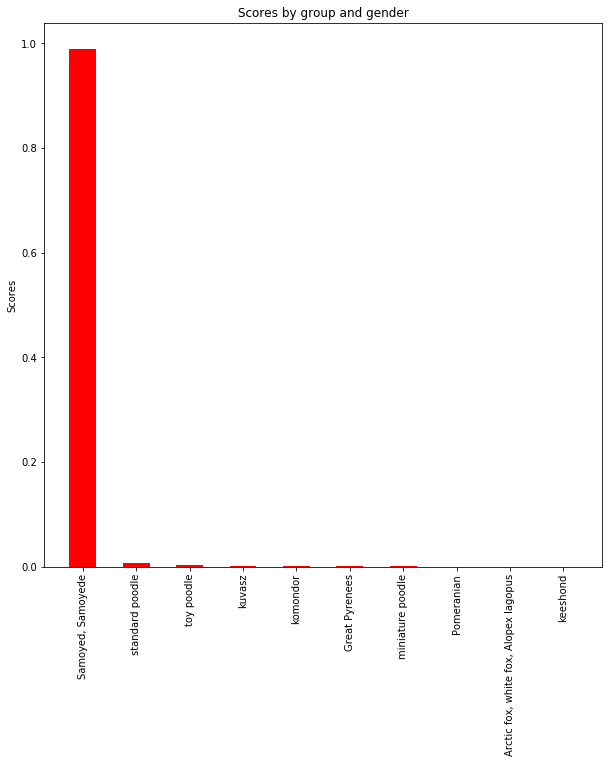

In [208]:
output_softmax = output_softmax[0]
figure = plt.figure(figsize=(10, 10))
N = 10
top_label_class_ids = np.argsort(output_softmax)[-1:0:-1][:N]


top_label_class_scores = output_softmax[top_label_class_ids]
ind = np.arange(N)  # the x locations for the groups
width = 0.5

ax = plt.gca()
rects1 = ax.bar(ind, top_label_class_scores, width, color='r')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
results = plt.xticks(ind, [imagenet_category_names[cat_id] for cat_id in top_args], rotation='vertical')


## Finetune Net

In [314]:
tensorboard_dir = './tensorboard_summaries'
if not os.path.isdir(tensorboard_dir):
    os.makedirs(tensorboard_dir)

tensorboard_fim_dir = os.path.join(tensorboard_dir, 'finetune_image')
if not os.path.isdir(tensorboard_fim_dir):
    os.makedirs(tensorboard_fim_dir)

In [315]:
experiemnt_name = 'experiment_1'
sprite_img_file = 'img_meta.png'
metadata_file = 'text_meta.tsv'

experiment_dir = os.path.join(tensorboard_fim_dir, experiemnt_name)
if not os.path.isdir(experiment_dir):
    os.makedirs(experiment_dir)

valid_writer_dir = os.path.join(experiment_dir, 'valid') 
train_writer_dir = os.path.join(experiment_dir, 'train')
sprite_img_path = os.path.join(valid_writer_dir, sprite_img_file)
metadata_file_path = os.path.join(valid_writer_dir, metadata_file)
model_path = os.path.join(valid_writer_dir, 'model.ckpt')

if not os.path.isdir(valid_writer_dir):
    os.makedirs(valid_writer_dir)
if not os.path.isdir(train_writer_dir):
    os.makedirs(train_writer_dir)

In [316]:
def get_sprite_img(images):
    image_size = len(images)
    image_shape = images[0].shape
    h, w = images[0].shape[:2]
    rows = int(np.ceil(np.sqrt(len(images))))
    cols = rows
    
    
    if len(image_shape) == 3:
        sprite_img = np.zeros([rows*h, cols*w, image_shape[2]])
    else:
        sprite_img = np.zeros([rows*h, cols*w])
    image_id = 0
    for row_id in range(rows):
        for col_id in range(cols):
            if image_id >= image_size:
                break

            row_pos = row_id * h
            col_pos = col_id * w

            sprite_img[row_pos:row_pos+h, col_pos:col_pos+w] = images[image_id]
            image_id += 1
    
    if len(image_shape) == 3:
        sprite_img = Image.fromarray(np.uint8(sprite_img))
    else:
        sprite_img = Image.fromarray(np.uint8(sprite_img * 0xFF))        

    return sprite_img
    
def get_label_class_names(label_class_onehots, class_id2class_name_mapping):
    return [class_id2class_name_mapping[int(c_id)] for c_id in np.argmax(label_class_onehots, axis=1).tolist()]


def save_label_class_names(label_class_names, path):
    with open(path, 'w') as fw:
        for name in label_class_names:
            fw.write(name + '\n')

In [317]:
def simple_layer(name, input_data, shape, activation='linear'):
    w_name = 'w_' + name
    b_name = 'b_' + name

    if activation == 'relu':
        w = tf.get_variable(w_name, shape=shape, initializer=tf.contrib.layers.variance_scaling_initializer())
    else:
        w = tf.get_variable(w_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    bias = tf.Variable(tf.zeros([shape[1]]), name=b_name)

    output_data = tf.matmul(input_data, w) + bias
    if activation == 'relu':
        output_data = tf.nn.relu(output_data)
    elif activation == 'sigmoid':
        output_data = tf.nn.sigmoid(output_data)
    return output_data

In [318]:
graph = tf.Graph()
label_size = 4
with graph.as_default():
    with tf.name_scope('inputs'):
        ph_image = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])
        ph_label = tf.placeholder(tf.float32, shape=(None, label_size), name='label')
        ph_is_training = tf.placeholder(tf.bool, shape=(), name='training_flag')

    with slim.arg_scope(resnet_v1.resnet_arg_scope()):
        resnet_tensors = resnet_v1.resnet_v1_50(ph_image,
                                                is_training=ph_is_training,
                                                num_classes=None,
                                                global_pool=True,
                                                scope='resnet_v1_50')
    resnet_feature_vector, resnet_endpoints = resnet_tensors

    with tf.name_scope('resnet_feature_vector'):
        resnet_feature_vector = tf.reshape(resnet_feature_vector, shape=(-1, 2048))

    with tf.name_scope('top_net_topo'):
        prediction_raw = resnet_feature_vector
        prediction_raw = simple_layer('layer1', prediction_raw, shape=[2048, 1024], activation='relu')
        prediction_raw = simple_layer('layer2', prediction_raw, shape=[1024, label_size], activation='linear')

    with tf.name_scope('prediction'):
        tf_prediction = tf.nn.softmax(prediction_raw)

    with tf.name_scope('loss'):
        tf_loss = tf.losses.softmax_cross_entropy(logits=prediction_raw, onehot_labels=ph_label)
        tf_loss = tf.reduce_mean(tf_loss)

    with tf.name_scope('accuracy'):
        tf_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(tf_prediction, 1), tf.argmax(ph_label, 1)), dtype=tf.float32))

    with tf.name_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([230, 2048]), name='valid_embedding')
        embedding_assignment = embedding.assign(resnet_feature_vector)       
    
    with tf.name_scope('train'):
        loss_to_optimize = tf_loss

        var_all = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        var_resnet = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='resnet_v1_50')
        var_resnet_3_and_4 = list(filter(lambda var: 'block3' in var.name or 'block4' in var.name, var_resnet))
        var_top = list(set(var_all) - set(var_resnet))

        gradients = tf.gradients(loss_to_optimize, var_resnet_3_and_4 + var_top)
        gradients_resnet = gradients[:len(var_resnet_3_and_4)]
        gradients_top = gradients[len(var_resnet_3_and_4):]

        optimizer_resnet = tf.train.AdamOptimizer(0.0001)
        optimizer_top = tf.train.AdamOptimizer(0.001)

        train_resnet = optimizer_resnet.apply_gradients(zip(gradients_resnet, var_resnet_3_and_4))
        train_top = optimizer_top.apply_gradients(zip(gradients_top, var_top))
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            tf_train_step = tf.group(train_resnet, train_top)

    tf_init_resnet = slim.assign_from_checkpoint_fn(
        resnet_model_ckpt, 
        slim.get_model_variables('resnet_v1_50'))
    
    tf_variables_initializer = tf.group(
        tf.global_variables_initializer(),
        tf.local_variables_initializer())


In [319]:
with graph.as_default():
    saver = tf.train.Saver()

valid_writer = tf.summary.FileWriter(valid_writer_dir, graph)
train_writer = tf.summary.FileWriter(train_writer_dir, graph)

In [320]:
data.validation.size = 80
images = data.validation.images
sprite_img = get_sprite_img(images)
sprite_img.save(sprite_img_path)

label_class_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)
save_label_class_names(label_class_names, metadata_file_path)

data.validation.size = 224


In [321]:
projector_config = projector.ProjectorConfig()
embedding_config = projector_config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.metadata_path = metadata_file
embedding_config.sprite.image_path = sprite_img_file
embedding_config.sprite.single_image_dim.extend([80, 80])
projector.visualize_embeddings(valid_writer, projector_config)

In [322]:
finetune_mapping = {
    0: 'cow',
    1: 'sheep',
    2: 'giraffe',
    3: 'horse'
}

In [323]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

valid_batch_labels = data.validation.labels
valid_batch_images = data.validation.images

with tf.Session(graph=graph, config=config) as session:
    session.run([tf_variables_initializer])
    tf_init_resnet(session)
    
    
    for iteration in range(50):
        train_batch_images, train_batch_labels = data.train.next_batch(30)
        _, train_loss, train_acc = session.run([tf_train_step, tf_loss, tf_accuracy], 
                                               feed_dict={ph_is_training: True, 
                                                          ph_image: train_batch_images, 
                                                          ph_label: train_batch_labels})
        
        if iteration % 10 == 0:
            _, valid_loss, valid_acc = session.run([embedding_assignment, tf_loss, tf_accuracy], 
                                                feed_dict={ph_is_training: False, 
                                                ph_image: valid_batch_images, 
                                                ph_label: valid_batch_labels})
            
            saver.save(session, model_path, iteration)
            print("Iteration:", iteration, "loss:", valid_loss, "acc:", valid_acc)
    saver.save(session, model_path, iteration)

INFO:tensorflow:Restoring parameters from data/checkpoints/resnet_v1_50.ckpt


INFO:tensorflow:Restoring parameters from data/checkpoints/resnet_v1_50.ckpt


Iteration: 0 loss: 10.2093 acc: 0.208696
Iteration: 10 loss: 1.32407 acc: 0.717391
Iteration: 20 loss: 3.00101 acc: 0.591304
Iteration: 30 loss: 2.02106 acc: 0.647826
Iteration: 40 loss: 1.49163 acc: 0.708696


KeyboardInterrupt: 

In [238]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

with graph.as_default():
    saver = tf.train.Saver(max_to_keep=5)

with tf.Session(graph=graph, config=config) as session:
    saver.restore(session, model_path)

        
    predictions, valid_loss, valid_acc = session.run([tf_prediction, tf_loss, tf_accuracy], 
        feed_dict={ph_is_training: False, 
                   ph_image: valid_batch_images, 
                   ph_label: valid_batch_labels})
    print("Loss:", valid_loss, "acc:", valid_acc)


INFO:tensorflow:Restoring parameters from data/checkpoints/test.ckpt


INFO:tensorflow:Restoring parameters from data/checkpoints/test.ckpt


Loss: 1.93038 acc: 0.7


In [245]:
def get_info_df(labels, predictions, images, class_id2class_name_mapping):
    predicted_class_ids_top1 = np.argmax(predictions, axis=1).tolist()
    predicted_class_ids_top3 = np.argsort(predictions, axis=1)[:,-3:].tolist()
    label_class_ids = np.argmax(labels, axis=1).tolist()

    label_class_names = [class_id2class_name_mapping[int(c_id)] for c_id in label_class_ids]
    label_class_scores = predictions[np.arange(len(labels)), label_class_ids].tolist()

    predicted_class_names_top1 = [class_id2class_name_mapping[int(c_id)] for c_id in predicted_class_ids_top1]
    predicted_class_scores_top1 = np.max(predictions, axis=1).tolist()

    predicted_class_names_top3 = []
    selection_class_ids_top3 = []
    
    for label_class_id, predicted_class_ids_triplet in zip(label_class_ids, predicted_class_ids_top3):
        class_id = label_class_id if label_class_id in predicted_class_ids_triplet else predicted_class_ids_triplet[0]
        selection_class_ids_top3.append(class_id)
        predicted_class_names_top3.append(class_id2class_name_mapping[class_id])
    predicted_class_scores_top3 = predictions[np.arange(len(labels)), selection_class_ids_top3].tolist()

    return pd.DataFrame(
        {'label_class_name': label_class_names,
         'label_class_score': label_class_scores,
         'predicted_class_name_top1': predicted_class_names_top1,
         'predicted_class_score_top1': predicted_class_scores_top1,
         'predicted_class_name_top3': predicted_class_names_top3,
         'predicted_class_score_top3': predicted_class_scores_top3,
         'image': list(images)
        })

In [248]:
df = get_info_df(data.validation.labels, predictions, data.validation.images, class_id2class_name_mapping)

In [249]:
def get_recall(info_df, class_name):
    true_positives = len(info_df[(info_df.label_class_name==class_name) & (info_df.predicted_class_name_top1==class_name)])
    trues = len(info_df[(info_df.label_class_name==class_name)])
    return round(true_positives / trues * 100, 2)

def get_precision(info_df, class_name):
    true_positives = len(info_df[(info_df.label_class_name==class_name) & (info_df.predicted_class_name_top1==class_name)])
    positives = len(info_df[(info_df.predicted_class_name_top1==class_name)])
    if positives == 0:
        positives = 1
    return round(true_positives / positives * 100, 2)
    
def get_accuracy(info_df):
    return round(float(np.mean((info_df.label_class_name == info_df.predicted_class_name_top1).astype(int))) * 100, 2)

def get_false_positives(info_df, label_class_name, predicted_class_name=None):
    if predicted_class_name is None:
        condition = (info_df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']!=label_class_name)
    else:
        condition = (info_df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']==predicted_class_name)
    return info_df[condition].sort_values(by='predicted_class_score_top1', ascending=False)


In [250]:
get_recall(df, 'cow')

75.0

In [251]:
get_precision(df, 'cow')

64.86

In [252]:
get_accuracy(df)

70.0

In [253]:
fp = get_false_positives(df, 'cow')

In [257]:
def plot_examples(info_df):
    fig = plt.figure(figsize=(20,25))

    examples_count = min(30, len(info_df))
    cols = 5
    rows = np.ceil(examples_count / cols)
    for img_id in range(examples_count):
        ax = plt.subplot(rows, cols, img_id+1)

        img = info_df.image.iloc[img_id].reshape((224,224,3))
        prediction_name = info_df.predicted_class_name_top1.iloc[img_id]
        prediction_score = info_df.predicted_class_score_top1.iloc[img_id]

        ax.imshow(img , cmap='gray')
        ax.set_title("{0}: {1}".format(prediction_name, round(prediction_score, 2)))
        ax.axes.set_axis_off()

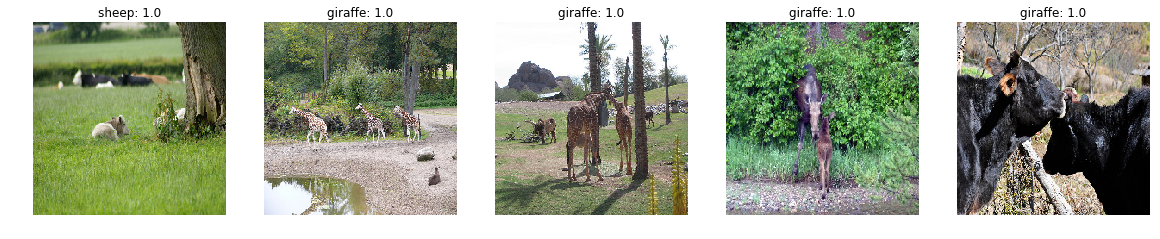

In [258]:
plot_examples(fp[:5])

In [259]:
def plot_coocurance_matrix(info_df, use_log=False, use_top3=False):
    if use_top3:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top3']
    else:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top1']
    coocurance_df = pd.pivot_table(info_df[coocurance_cols], index=coocurance_cols[0], 
                                   columns=coocurance_cols[1], aggfunc=len, fill_value=0)
    if use_log:
        coocurance_df = np.log(coocurance_df)
        coocurance_df = coocurance_df.replace([-np.inf], 0)

    coocurance_df = coocurance_df.div(coocurance_df.sum(axis=1), axis=0) * 100
    coocurance_df = coocurance_df.round(2)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    sns.heatmap(coocurance_df, ax=ax, annot=True,  linewidths=.5, 
                cbar_kws={"orientation": "horizontal"}, cmap="YlGnBu")

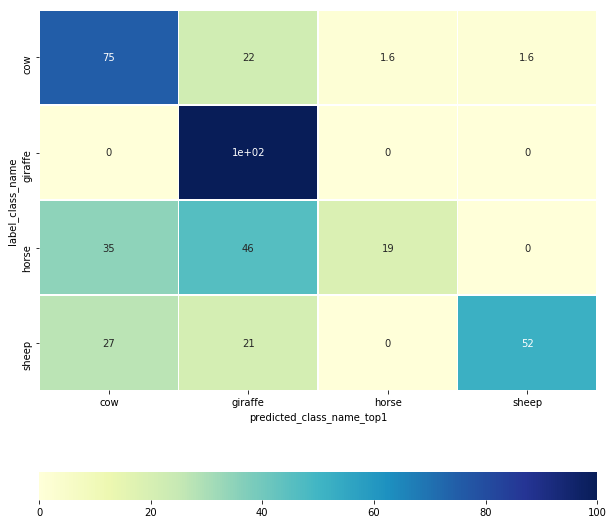

In [261]:
plot_coocurance_matrix(df, use_log=False)

In [262]:
def get_rec_prec(info_df, class_id2class_name_mapping):
    return pd.DataFrame(
        {
            "class_name": [class_name for class_name in class_id2class_name_mapping.values()],
            "recall": [get_recall(info_df, class_name) for class_name in class_id2class_name_mapping.values()],
            "precision": [get_precision(info_df, class_name) for class_name in class_id2class_name_mapping.values()]
        })

In [263]:
get_rec_prec(df, class_id2class_name_mapping)

class_name  precision  recall
0        cow      64.86   75.00
1      sheep      96.15   52.08
2    giraffe      66.39  100.00
3      horse      87.50   18.92